In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neural_network
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import metrics
import plotly.express as px
import gc

import xgboost as xgb

SEED = 42

cat_feat_colors = ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1", "#a4a2a8", "#df8879", "#c86558", "#b04238", "#991f17"]
colors = ['#FFB6B9', '#FAE3D9', '#BBDED6', '#61C0BF', "#CCA8E9", "#F67280"]

In [2]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df


def check_df(dataframe, head=5, tail=5):
    print("*" * 70)
    print(" Shape ".center(70, "*"))
    print("*" * 70)
    print(dataframe.shape)

    print("*" * 70)
    print(" Types ".center(70, "*"))
    print("*" * 70)
    print(dataframe.dtypes)

    print("*" * 70)
    print(" Head ".center(70, "*"))
    print("*" * 70)
    print(dataframe.head(head))

    print("*" * 70)
    print(" Tail ".center(70, "*"))
    print("*" * 70)
    print(dataframe.tail(tail))

    print("*" * 70)
    print(" NA ".center(70, "*"))
    print("*" * 70)
    print(missing_values_analysis(dataframe))

    print("*" * 70)
    print(" Quantiles ".center(70, "*"))
    print("*" * 70)
    print(dataframe.describe([.01, .05, .1, .5, .9, .95, .99]).T)

    print("*" * 70)
    print(" Duplicate Rows ".center(70, "*"))
    print("*" * 70)
    print(dataframe.duplicated().sum())

    print("*" * 70)
    print(" Uniques ".center(70, "*"))
    print("*" * 70)
    print(dataframe.nunique())

In [32]:
def cat_plots(dataframe, cat_col):
    print("".center(100, "#"))
    print(dataframe[cat_col].value_counts())
    print("".center(100, "#"))

    plt.figure(figsize=(15, 10))
    sns.set_style("whitegrid")
    #plt.suptitle(cat_col.capitalize(), size=16)
    plt.subplot(1, 3, 1)
    plt.title("Percentages")
    plt.pie(dataframe[cat_col].value_counts().values.tolist(),
            labels=dataframe[cat_col].value_counts().keys().tolist(),
            labeldistance=1.1,
            wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
            colors=colors,
            autopct='%1.0f%%')

    if type(cat_col) == str:
        plt.subplot(1, 3, 2)
        plt.title("Countplot")
        sns.countplot(data=dataframe, x=cat_col, palette=colors)
        plt.tight_layout(pad=3)
    else:
        plt.subplot(1, 3, 2)
        plt.title("Countplot")
        sns.countplot(data=dataframe, x=cat_col[0], hue=cat_col[1], palette=colors)
        plt.tight_layout(pad=3)
        
    
    

In [ ]:
class Ensemble(object):
    
    def __init__(self, k, stacker, base_models):
        
        self.k = k # How many folds used in cross validation
        
        self.stacker = stacker # Final model used for stacking
        
        self.base_models = base_models # Base models in specific layers

    def fit_predict(self, X, y, pred_matrix):
        """
        This function calculates the meta features for each layer.
        """
        X = np.array(X) 
        
        y = np.array(y) 
        
        pred_matrix = np.array(pred_matrix)

        kf = KFold(n_splits=self.k, shuffle=True, random_state=0) # Split the train data into k folds

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        
        S_test = np.zeros((pred_matrix.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models): # Iterate through the base models in a layer
            S_test_i = np.zeros((pred_matrix.shape[0], self.k))

            for j, (train_idx, test_idx) in enumerate(kf.split(X)):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                clf.fit(X_train, y_train) # Fit the specific base model
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(pred_matrix)[:]

            S_test[:, i] = S_test_i.mean(1)
            
        self.stacker.fit(S_train, y)
        
        y_pred = self.stacker.predict(S_test)[:]
    
        return S_train, y_pred, S_test
    
    def layer_pred(self, num_layer, X_input, Y_input, base_models, models, pred_matrix, endmodel):
        """
        This function reads in the train and test data, iterates through the layers,
        and outputs the predictions.
        """
        # level 1:
        S_train, y_pred, S_test = self.fit_predict(X_input, Y_input, pred_matrix)
        # level num_layer:
        ##BEGIN iteration##
        for index in range(0,num_layer):
            
            self.base_models = models[index] 

            S_train, y_pred, S_test = self.fit_predict(S_train, Y_input, S_test)
            
        ##END iteration##
        
        endmodel.fit(S_train, Y_input)
        
        y_pred = endmodel.predict(S_test)[:]
        
        return y_pred

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
check_df(data)

**********************************************************************
******************************* Shape ********************************
**********************************************************************
(7043, 21)
**********************************************************************
******************************* Types ********************************
**********************************************************************
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Chu

In [3]:
df = data.copy()

In [4]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [5]:
df.dropna(inplace=True)

In [69]:
df.TotalCharges.isnull().value_counts()

False    7032
Name: TotalCharges, dtype: int64

In [6]:
df.drop(columns="customerID", inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [8]:
df["Churn"].replace(to_replace="Yes", value= 1, inplace=True)
df["Churn"].replace(to_replace="No", value= 0, inplace=True)

df_dummies = pd.get_dummies(df)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [76]:
df_dummies["Churn"].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

####################################################################################################
Male      3549
Female    3483
Name: gender, dtype: int64
####################################################################################################


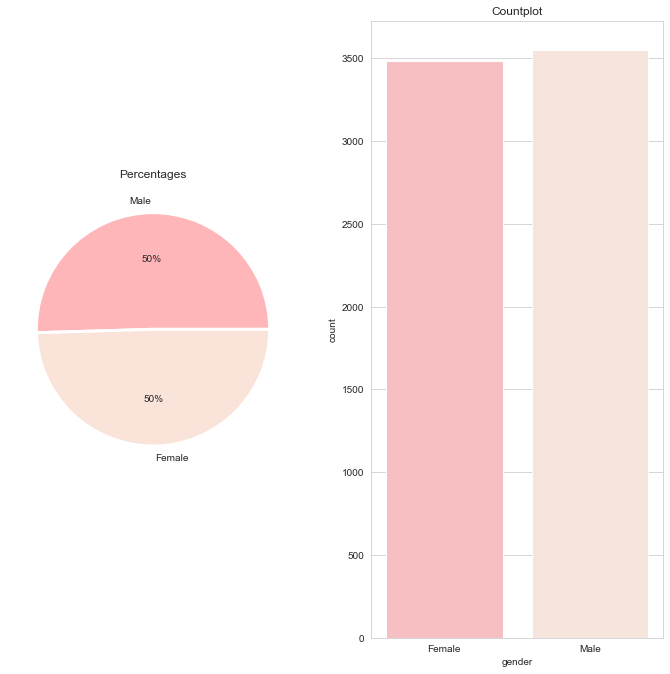

In [82]:
cat_plots(df, "gender")

####################################################################################################
0    5890
1    1142
Name: SeniorCitizen, dtype: int64
####################################################################################################


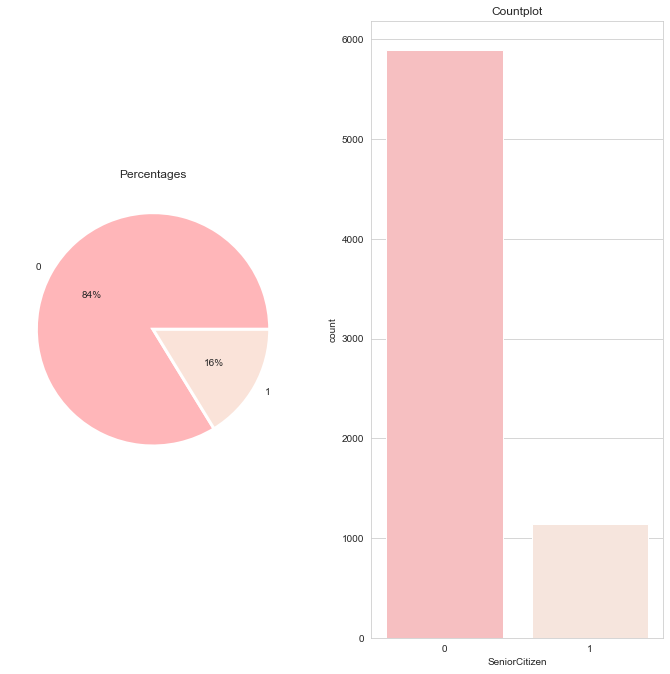

In [85]:
cat_plots(df, "SeniorCitizen")

####################################################################################################
No     3639
Yes    3393
Name: Partner, dtype: int64
####################################################################################################


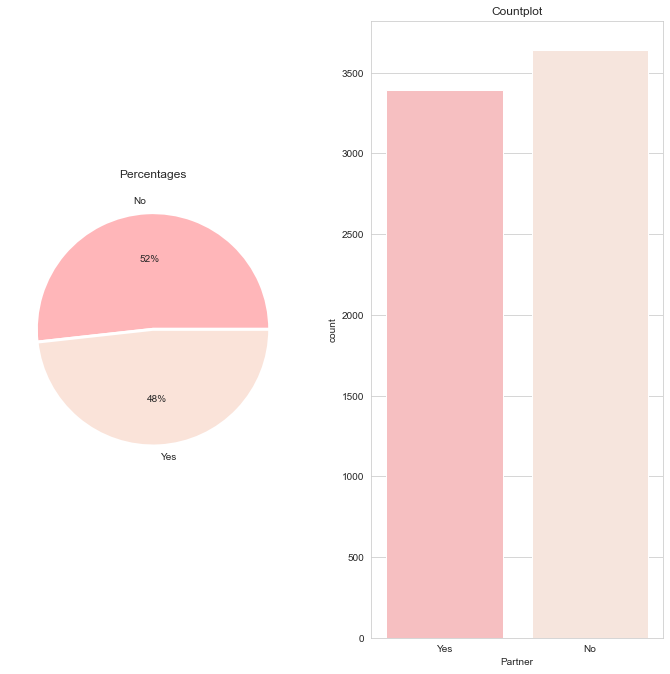

In [86]:
cat_plots(df, "Partner")

####################################################################################################
Partner  Dependents
No       No            3280
Yes      Yes           1740
         No            1653
No       Yes            359
dtype: int64
####################################################################################################


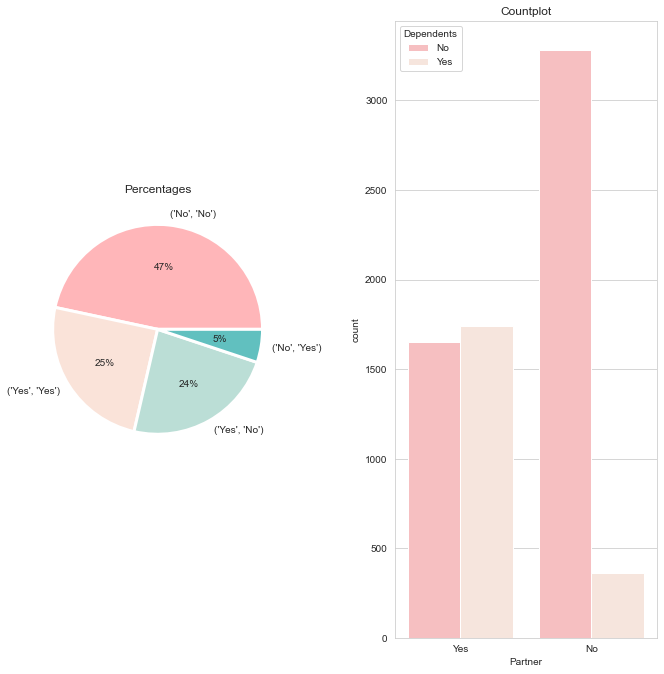

In [90]:
cat_plots(df, ["Partner", "Dependents"])

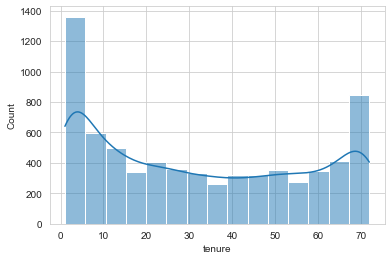

In [99]:
sns.histplot(df["tenure"], kde=True);

####################################################################################################
SeniorCitizen  gender
0              Male      2975
               Female    2915
1              Male       574
               Female     568
dtype: int64
####################################################################################################


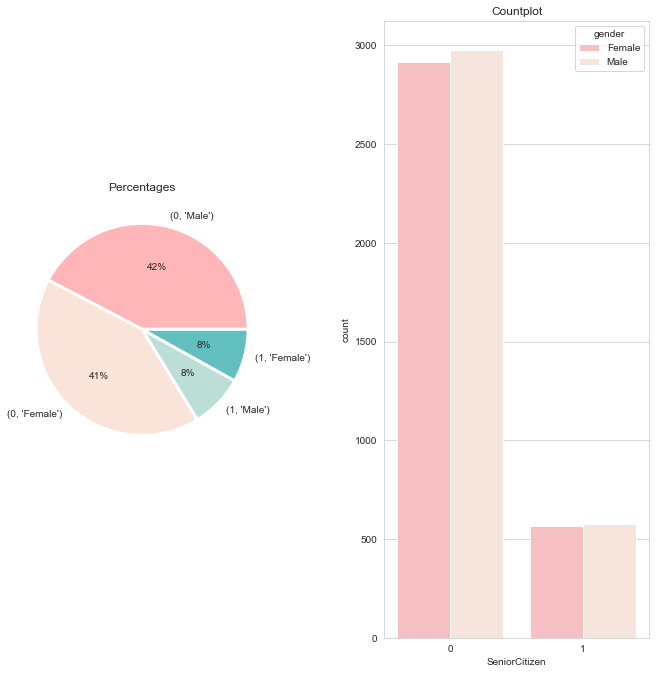

In [122]:
cat_plots(df, ["SeniorCitizen", "gender"])

####################################################################################################
Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64
####################################################################################################


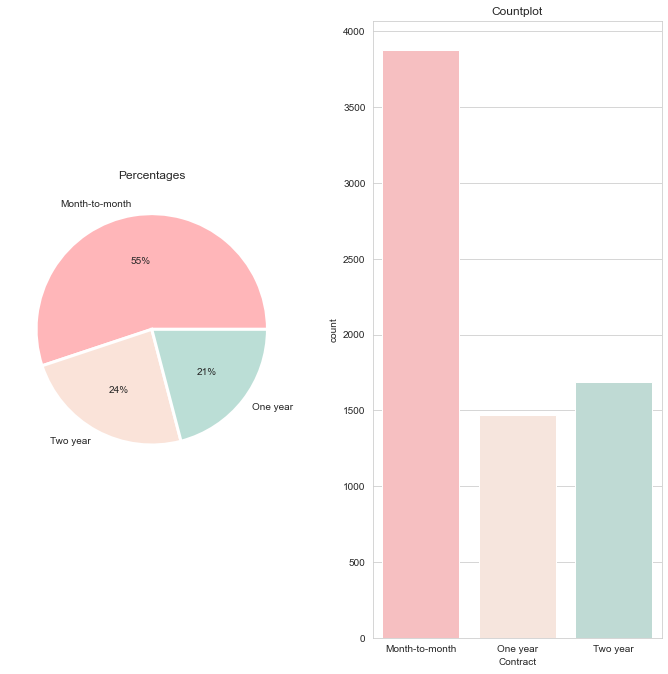

In [109]:
cat_plots(df, "Contract")

c:\Users\Furka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Furka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Furka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

Text(0.5, 1.0, 'Two Year Contract')

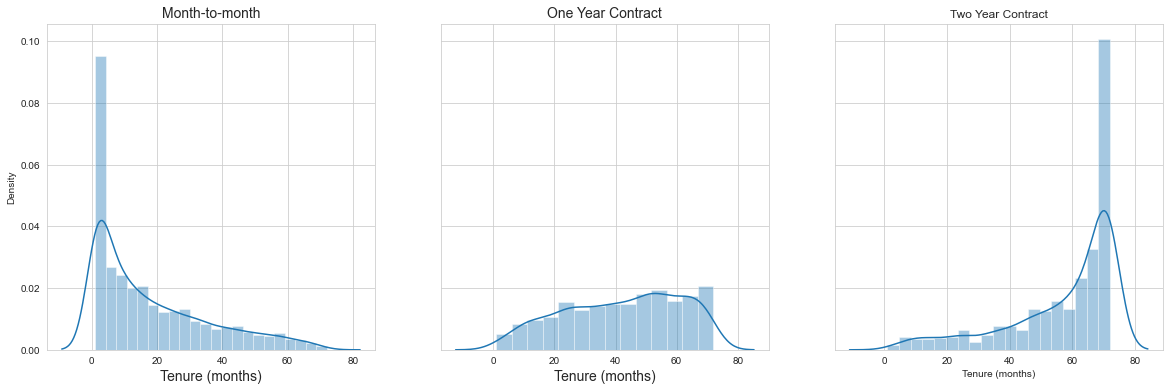

In [118]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))
ax= sns.distplot(df[df['Contract']=='Month-to-month']['tenure'], ax=ax1);
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('Month-to-month',size = 14)
ax= sns.distplot(df[df['Contract']=='One year']['tenure'], ax=ax2);
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)
ax= sns.distplot(df[df['Contract']=='Two year']['tenure'], ax=ax3);
ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')


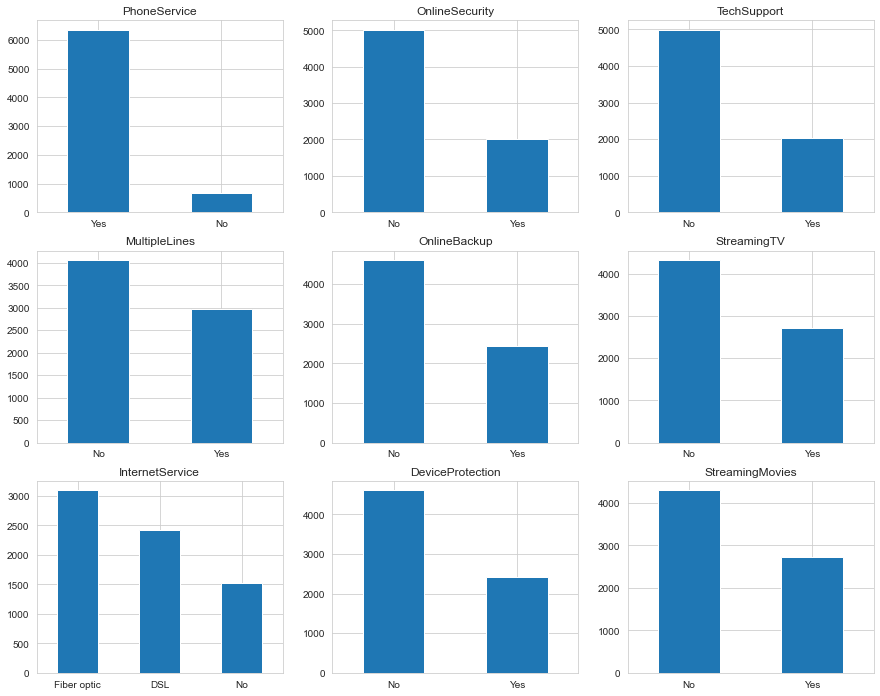

In [131]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

####################################################################################################
0    5163
1    1869
Name: Churn, dtype: int64
####################################################################################################


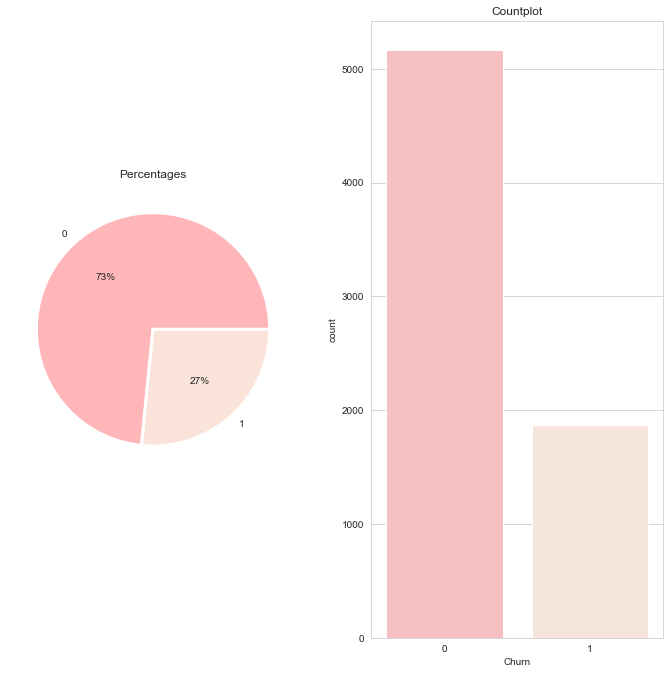

In [132]:
cat_plots(df, "Churn")

In data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

<AxesSubplot:xlabel='Churn', ylabel='Contract'>

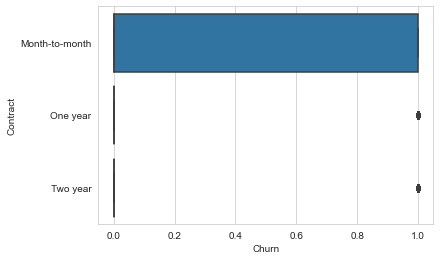

In [139]:
sns.boxplot(x= df["Churn"], y=df["Contract"], data=df)

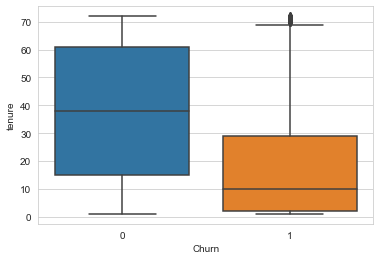

In [141]:
sns.boxplot(x= df["Churn"], y=df["tenure"], data=df);


In [24]:
print(df["TotalCharges"].quantile(0.75))

3794.7375


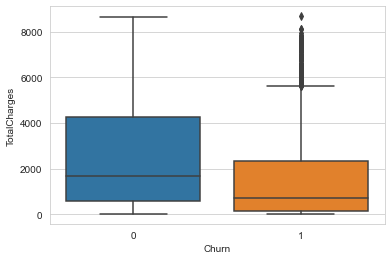

In [142]:
sns.boxplot(x= df["Churn"], y=df["TotalCharges"], data=df);


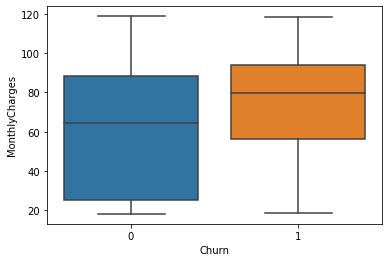

In [12]:
sns.boxplot(x= df["Churn"], y=df["MonthlyCharges"], data=df);


In [10]:
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [23]:
df_dummies[(df_dummies["TotalCharges"] > 6000) & (df_dummies.Churn == 1)]

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
104,0,68,110.00,7611.85,1,0,1,0,1,1,...,1,0,0,1,0,1,1,0,0,0
339,0,63,103.40,6603.00,1,0,1,0,1,1,...,1,1,0,0,0,1,0,0,1,0
402,0,69,99.45,7007.60,1,0,1,0,1,0,...,1,1,0,0,0,1,0,1,0,0
445,0,60,105.90,6396.45,1,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
609,1,65,105.25,6786.40,1,1,0,0,1,1,...,1,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6785,0,61,111.60,6876.05,1,0,1,1,0,1,...,1,0,0,1,0,1,0,1,0,0
6853,0,54,111.10,6014.85,1,1,0,1,0,1,...,1,1,0,0,1,0,0,0,1,0
6945,0,70,98.30,6859.50,1,0,1,0,1,0,...,1,0,0,1,1,0,1,0,0,0
6972,1,56,111.95,6418.90,1,1,0,1,0,1,...,1,0,1,0,0,1,0,0,1,0


####################################################################################################
Churn  Contract      
0      Month-to-month    2220
1      Month-to-month    1655
0      Two year          1637
       One year          1306
1      One year           166
       Two year            48
dtype: int64
####################################################################################################


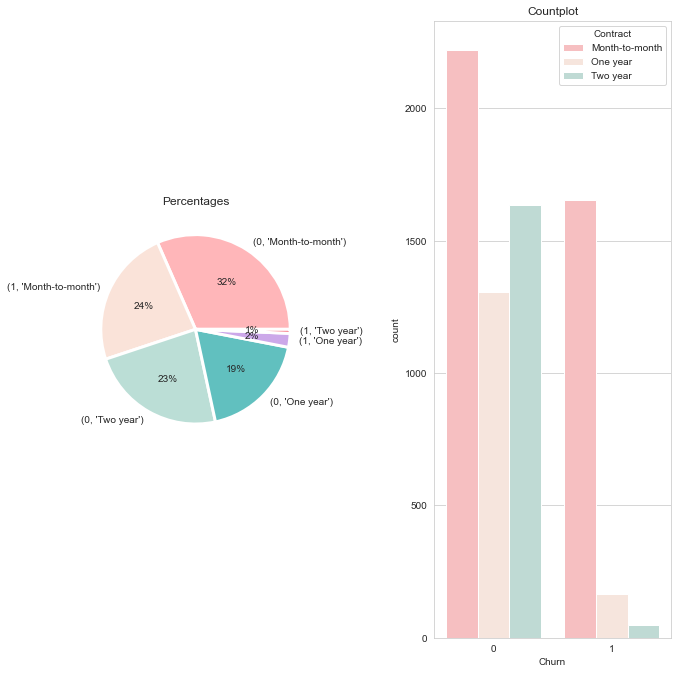

In [153]:
cat_plots(df, ["Churn", "Contract"])

####################################################################################################
Churn  InternetService
0      DSL                1957
       Fiber optic        1799
       No                 1407
1      Fiber optic        1297
       DSL                 459
       No                  113
dtype: int64
####################################################################################################


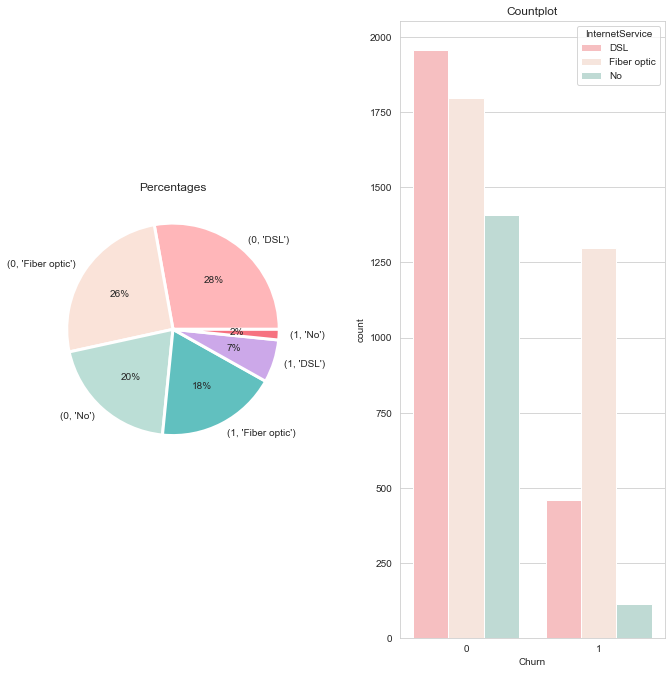

In [154]:
cat_plots(df, ["Churn", "InternetService"])

####################################################################################################
Churn  SeniorCitizen
0      0                4497
1      0                1393
0      1                 666
1      1                 476
dtype: int64
####################################################################################################


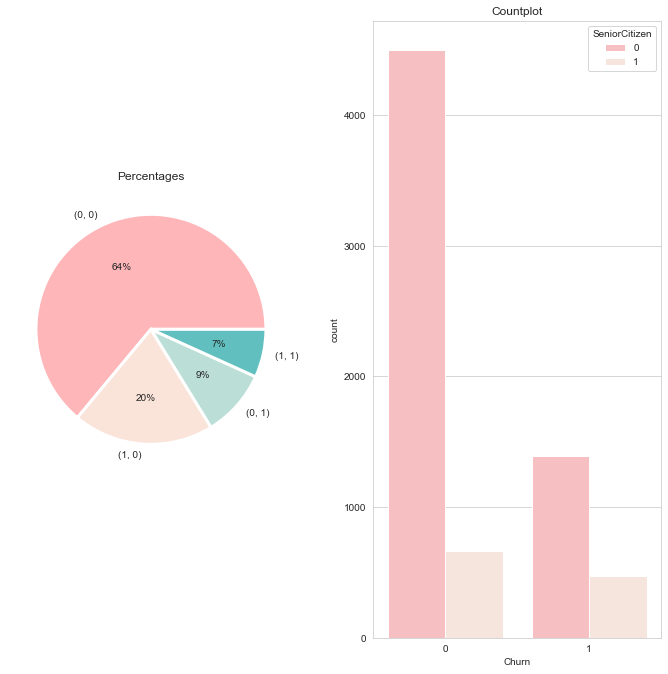

In [155]:
cat_plots(df, ["Churn", "SeniorCitizen"])

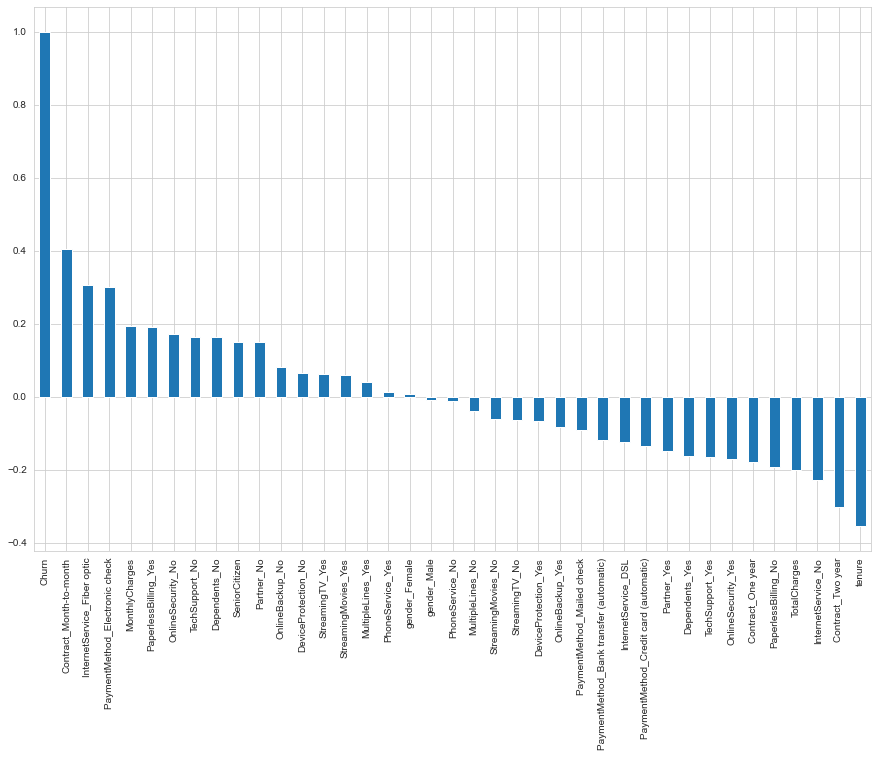

In [81]:
plt.figure(figsize=(15,10))
df_dummies.corr()['Churn'].sort_values(ascending=False).plot(kind='bar');

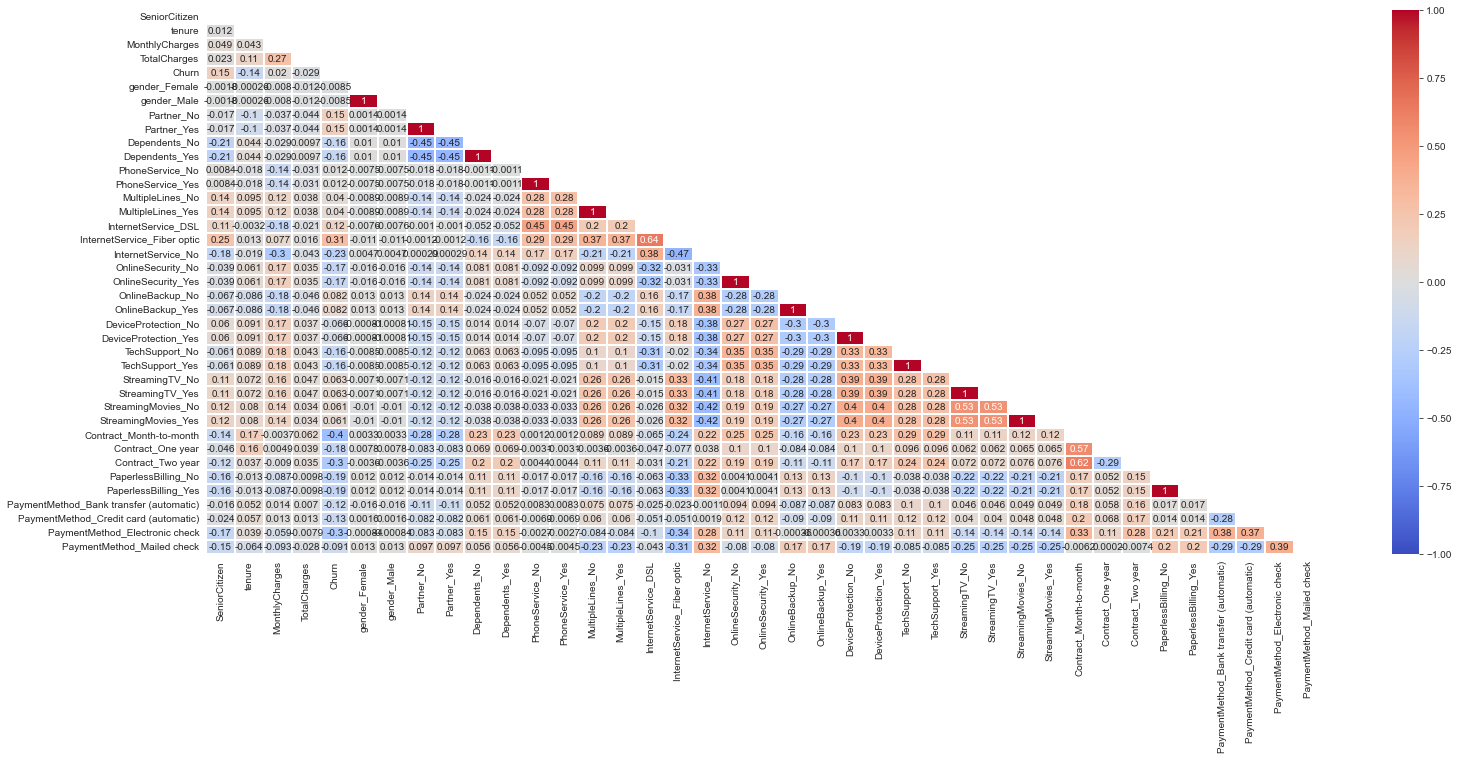

In [80]:
plt.figure(figsize=(25, 10))

corr = df_dummies.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [26]:
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [30]:
model = LogisticRegression()
result = model.fit(X_train, y_train)

c:\Users\Furka\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [31]:
prediction_test = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.7874911158493249


AxesSubplot(0.125,0.125;0.775x0.755)


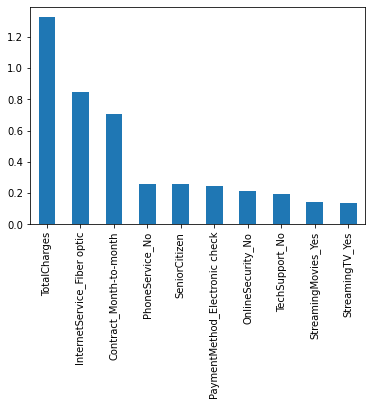

In [32]:
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


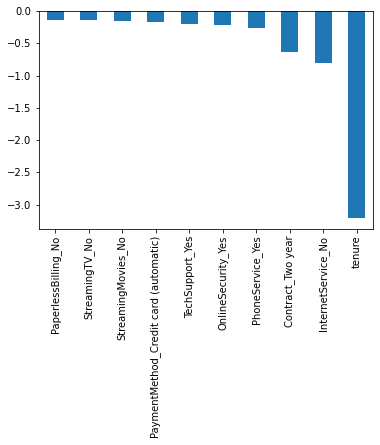

In [33]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

c:\Users\Furka\anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


0.7889125799573561


<AxesSubplot:>

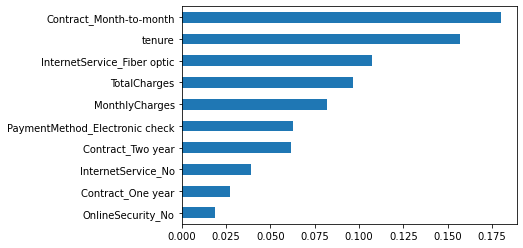

In [37]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [39]:
model.svm = SVC(kernel='linear') 
model.svm.fit(X_train,y_train)
preds = model.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.7938877043354655

In [41]:
print(confusion_matrix(y_test,preds))

[[917 116]
 [174 200]]


In [48]:
model = AdaBoostClassifier(random_state=SEED)
model.fit(X_train,y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.7931769722814499

In [49]:
model = xgb.XGBClassifier(random_state=SEED)
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.7725657427149965

In [50]:
clf_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate= 0.1,
    subsample=0.8,
    colsample_bytree=0.2,
    random_state = SEED
)
clf_xgb.fit(X_train, y_train)
accuracy_xgb = clf_xgb.score(X_test, y_test)
print(accuracy_xgb)

0.7690120824449183


In [51]:
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=SEED
)
clf_rf.fit(X_train, y_train)
accuracy_rf = clf_rf.score(X_test, y_test)
print(accuracy_rf)

0.7874911158493249


In [54]:
clf_nn = keras.Sequential([
    # input layer
    keras.layers.Dense(38, input_shape=(38,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1,activation = 'sigmoid'),
    # we use sigmoid for binary output
    # output layer
]
)

In [55]:
# time for compilation of neural net.
clf_nn.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
# now we fit our model to training data
clf_nn.fit(X_train, y_train, epochs=100)

Epoch 1/100
176/176 [==============================] - 1s 2ms/step - loss: 0.4853 - accuracy: 0.7620
Epoch 2/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4238 - accuracy: 0.8009
Epoch 3/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4172 - accuracy: 0.7995
Epoch 4/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4159 - accuracy: 0.8004
Epoch 5/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4119 - accuracy: 0.8059
Epoch 6/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4090 - accuracy: 0.8082
Epoch 7/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4074 - accuracy: 0.8071
Epoch 8/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4074 - accuracy: 0.8096
Epoch 9/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4044 - accuracy: 0.8094
Epoch 10/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4026 - accura

In [56]:
clf_nn.evaluate(X_test, y_test)

44/44 [==============================] - 0s 930us/step - loss: 0.5565 - accuracy: 0.7576


[0.5565429925918579, 0.7576403617858887]

In [58]:
level1 = [neural_network.MLPClassifier(hidden_layer_sizes=(1000, 15), random_state = SEED, max_iter = 500),ensemble.RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED), xgb.XGBClassifier(n_estimators=40, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, random_state = SEED)]
level2 = [xgb.XGBClassifier(), linear_model.LogisticRegression()]

In [59]:
models = {0: level2}

In [60]:
fitter_three = Ensemble(10, xgb.XGBClassifier(), level1)
#y_stack1_fitter_three = fitter_three.layer_pred(1, x1, y1, level1, models, x2, xgb.XGBRegressor()) -------x2 = x_test

In [61]:
y_stack1_fitter_three = fitter_three.layer_pred(1, X_train, y_train, level1, models, X_test, xgb.XGBClassifier()) 

In [62]:
y_stack1_fitter_three.shape

(1407,)

In [63]:
print(accuracy_score(y_test, y_stack1_fitter_three), precision_score(y_test, y_stack1_fitter_three))

0.7931769722814499 0.6666666666666666


In [64]:
print(accuracy_score(y_test, y_stack1_fitter_three), precision_score(y_test, y_stack1_fitter_three)) #max_iter = 500


0.7931769722814499 0.6666666666666666
